# 2D Latent Diffusion Model

Training an LDM to create synthetic ChestCT images from the MEDNIST dataset.

[1] - Rombach et al. "High-Resolution Image Synthesis with Latent Diffusion Models" https://arxiv.org/abs/2112.10752

[2] - Pinaya et al. "Brain imaging generation with latent diffusion models" https://arxiv.org/abs/2209.07162


### Set up environment

In [1]:
!pip install monai
!pip install monai-generative

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [3]:
!pip install lpips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.7 MB/s eta 0:00:00


### Setup imports

In [4]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import LatentDiffusionInferer
from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.3.0
Numpy version: 1.25.2
Pytorch version: 2.2.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.17.1+cu121
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.38.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
   

### Set deterministic training for reproducibility

In [5]:
set_determinism(42)

### Setup a data directory and download dataset
Specify a MONAI_DATA_DIRECTORY variable, where the data will be downloaded. If not specified a temporary directory will be used.

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpe90k03v_


## Prepare training set data loader

Using only the `ChestCT` class.
Data augmentation performed by the `RandAffine` transformation in the data transformations.

In [7]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "ChestCT"]
image_size = 64
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = Dataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

MedNIST.tar.gz: 59.0MB [00:01, 31.9MB/s]                            

2024-03-16 14:02:10,124 - INFO - Downloaded: /tmp/tmpe90k03v_/MedNIST.tar.gz


2024-03-16 14:02:10,318 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-03-16 14:02:10,324 - INFO - Writing into directory: /tmp/tmpe90k03v_.


Loading dataset: 100%|██████████| 47164/47164 [00:34<00:00, 1356.55it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualise examples from the training set

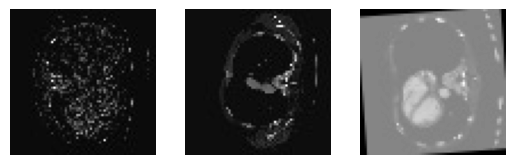

In [8]:
# Plot 3 examples from the training set
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(check_data["image"][image_n, 0, :, :], cmap="gray")
    ax[image_n].axis("off")

## Prepare validation set data loader

In [25]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "ChestCT"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

2024-03-16 14:30:38,399 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-03-16 14:30:38,405 - INFO - File exists: /tmp/tmpe90k03v_/MedNIST.tar.gz, skipped downloading.
2024-03-16 14:30:38,409 - INFO - Non-empty folder exists in /tmp/tmpe90k03v_/MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 5895/5895 [00:04<00:00, 1253.05it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Autoencoder KL

### Define Autoencoder KL network, losses and optimiser

In this section, we define an autoencoder with KL-regularization for the LDM. The autoencoder's primary purpose is to transform input images into a latent representation that the diffusion model will subsequently learn. Also specify the perceptual and adversarial losses, including the involved networks, and the optimizers to use during the training process.

In [26]:
device = torch.device("cuda")

autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 128, 256),
    latent_channels=3,
    num_res_blocks=2,
    attention_levels=(False, False, False),
    with_encoder_nonlocal_attn=False,
    with_decoder_nonlocal_attn=False,
)
autoencoderkl = autoencoderkl.to(device)

In [27]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)
perceptual_weight = 0.001

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
discriminator = PatchDiscriminator(spatial_dims=2, num_layers_d=3, num_channels=64, in_channels=1, out_channels=1)
discriminator = discriminator.to(device)

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01

In [29]:
optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)

# For mixed precision training
scaler_g = torch.cuda.amp.GradScaler()
scaler_d = torch.cuda.amp.GradScaler()

### Train model

In [30]:
kl_weight = 1e-6
n_epochs = 40
val_interval = 10
autoencoder_warm_up_n_epochs = 5

epoch_recon_losses = []
epoch_gen_losses = []
epoch_disc_losses = []
val_recon_losses = []
intermediary_images = []
num_example_images = 4

for epoch in range(n_epochs):
    autoencoderkl.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = autoencoderkl(images)

            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            with autocast(enabled=True):
                optimizer_d.zero_grad(set_to_none=True)

                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_losses.append(epoch_loss / (step + 1))
    epoch_gen_losses.append(gen_epoch_loss / (step + 1))
    epoch_disc_losses.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                with autocast(enabled=True):
                    reconstruction, z_mu, z_sigma = autoencoderkl(images)
                    # Get the first reconstruction from the first validation batch for visualisation purposes
                    if val_step == 1:
                        intermediary_images.append(reconstruction[:num_example_images, 0])

                    recons_loss = F.l1_loss(images.float(), reconstruction.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_losses.append(val_loss)
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")
progress_bar.close()

del discriminator
del perceptual_loss
torch.cuda.empty_cache()

Epoch 9: 100%|█████████| 126/126 [00:31<00:00,  4.03it/s, recons_loss=0.0265, gen_loss=0.599, disc_loss=0.305]


epoch 10 val loss: 0.0318


Epoch 19: 100%|████████| 126/126 [00:32<00:00,  3.87it/s, recons_loss=0.0232, gen_loss=0.453, disc_loss=0.214]


epoch 20 val loss: 0.0246


Epoch 29: 100%|███████| 126/126 [00:32<00:00,  3.85it/s, recons_loss=0.0239, gen_loss=0.807, disc_loss=0.0915]


epoch 30 val loss: 0.0233


Epoch 39: 100%|██████████| 126/126 [00:33<00:00,  3.77it/s, recons_loss=0.018, gen_loss=0.32, disc_loss=0.236]


epoch 40 val loss: 0.0204


### Visualise the results from the autoencoderKL

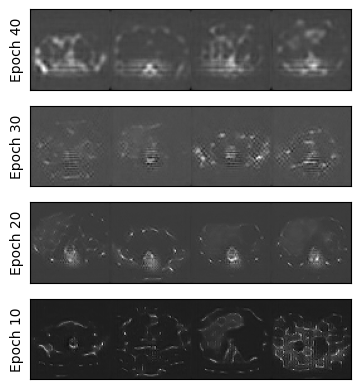

In [34]:
# Plot last 5 evaluations
val_samples = np.linspace(n_epochs, val_interval, int(n_epochs / val_interval))
fig, ax = plt.subplots(nrows=4, ncols=1, sharey=True)
for image_n in range(4):
    reconstructions = torch.reshape(intermediary_images[image_n], (image_size * num_example_images, image_size)).T
    ax[image_n].imshow(reconstructions.cpu(), cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

In [35]:
import pickle
with open('autoencoderkl_model_chestCT.pkl', 'wb') as f:
    pickle.dump(autoencoderkl, f)

## Diffusion Model

### Define diffusion model and scheduler

Define the diffusion model that will learn data distribution of the latent representation of the autoencoder. Define a beta scheduler responsible for defining the amount of noise tahat is added across the diffusion's model Markov chain.

In [36]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_res_blocks=2,
    num_channels=(128, 256, 512),
    attention_levels=(False, True, True),
    num_head_channels=(0, 256, 512),
)

scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)

### Scaling factor

As mentioned in Rombach et al. [1] Section 4.3.2 and D.1, the signal-to-noise ratio (induced by the scale of the latent space) can affect the results obtained with the LDM, if the standard deviation of the latent space distribution drifts too much from that of a Gaussian. For this reason, it is best practice to use a scaling factor to adapt this standard deviation.

In [37]:
with torch.no_grad():
    with autocast(enabled=True):
        z = autoencoderkl.encode_stage_2_inputs(check_data["image"].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to 0.9374432563781738


We define the inferer using the scale factor:

In [38]:
inferer = LatentDiffusionInferer(scheduler, scale_factor=scale_factor)

### Train diffusion model


Epoch 39: 100%|██████████| 126/126 [00:37<00:00,  3.35it/s, loss=0.13]


Epoch 39 val loss: 0.1358


100%|██████████| 1000/1000 [00:26<00:00, 37.66it/s]


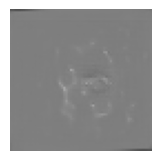

Epoch 79: 100%|█████████| 126/126 [00:37<00:00,  3.38it/s, loss=0.122]


Epoch 79 val loss: 0.1309


100%|██████████| 1000/1000 [00:26<00:00, 37.47it/s]


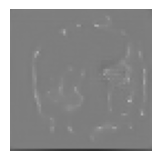

Epoch 99: 100%|█████████| 126/126 [00:36<00:00,  3.41it/s, loss=0.124]


In [39]:
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)

unet = unet.to(device)
n_epochs = 100
val_interval = 40
epoch_losses = []
val_losses = []
scaler = GradScaler()

for epoch in range(n_epochs):
    unet.train()
    autoencoderkl.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=True):
            z_mu, z_sigma = autoencoderkl.encode(images)
            z = autoencoderkl.sampling(z_mu, z_sigma)
            noise = torch.randn_like(z).to(device)
            timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device).long()
            noise_pred = inferer(
                inputs=images, diffusion_model=unet, noise=noise, timesteps=timesteps, autoencoder_model=autoencoderkl
            )
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_losses.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                with autocast(enabled=True):
                    z_mu, z_sigma = autoencoderkl.encode(images)
                    z = autoencoderkl.sampling(z_mu, z_sigma)

                    noise = torch.randn_like(z).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
                    ).long()
                    noise_pred = inferer(
                        inputs=images,
                        diffusion_model=unet,
                        noise=noise,
                        timesteps=timesteps,
                        autoencoder_model=autoencoderkl,
                    )

                    loss = F.mse_loss(noise_pred.float(), noise.float())

                val_loss += loss.item()
        val_loss /= val_step
        val_losses.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Sampling image during training
        z = torch.randn((1, 3, 16, 16))
        z = z.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            decoded = inferer.sample(
                input_noise=z, diffusion_model=unet, scheduler=scheduler, autoencoder_model=autoencoderkl
            )

        plt.figure(figsize=(2, 2))
        plt.style.use("default")
        plt.imshow(decoded[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()
progress_bar.close()


### Plot learning curves

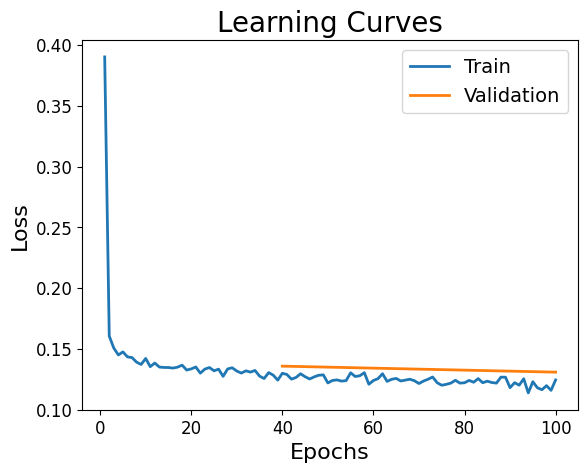

In [40]:
plt.figure()
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_losses, linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)), val_losses, linewidth=2.0, label="Validation"
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})

### Plotting sampling example

Generate an image with our LDM. For that, we will initialize a latent representation with just noise. Then, we will use the `unet` to perform 1000 denoising steps. For every 100 steps, we store the noisy intermediary samples. In the last step, we decode all latent representations and plot how the image looks like across the sampling process.

In [41]:
unet.eval()
scheduler.set_timesteps(num_inference_steps=1000)
noise = torch.randn((1, 3, 16, 16))
noise = noise.to(device)

with torch.no_grad():
    image, intermediates = inferer.sample(
        input_noise=noise,
        diffusion_model=unet,
        scheduler=scheduler,
        save_intermediates=True,
        intermediate_steps=100,
        autoencoder_model=autoencoderkl,
    )

100%|██████████| 1000/1000 [00:22<00:00, 44.42it/s]


(-0.5, 639.5, 63.5, -0.5)

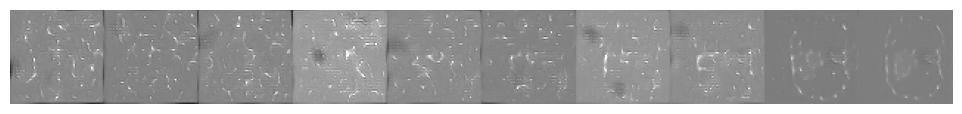

In [65]:
# Decode latent representation of the intermediary images
decoded_images = []
for image in intermediates:
    with torch.no_grad():
        decoded_images.append(image)
plt.figure(figsize=(10, 12))
chain = torch.cat(decoded_images, dim=-1)
plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")

In [43]:
with open('diffusion_unet_model_chestCT.pkl', 'wb') as f:
    pickle.dump(unet, f)

##Compute FID score and MMD

In [44]:
from generative.metrics import FIDMetric, MMDMetric

In [45]:
radnet = torch.hub.load("Warvito/radimagenet-models", model="radimagenet_resnet50", verbose=True)
radnet.to(device)
radnet.eval()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/Warvito/radimagenet-models/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1VOWHgOq0rm7OkE_JxlWXhMAH4CvcXUHT
From (redirected): https://drive.google.com/uc?export=download&id=1VOWHgOq0rm7OkE_JxlWXhMAH4CvcXUHT&confirm=t&uuid=a221b2ad-156e-4d0

ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1.001e-05, momentum=0.01, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm

In [46]:
def subtract_mean(x: torch.Tensor) -> torch.Tensor:
    mean = [0.406, 0.456, 0.485]
    x[:, 0, :, :] -= mean[0]
    x[:, 1, :, :] -= mean[1]
    x[:, 2, :, :] -= mean[2]
    return x


def spatial_average(x: torch.Tensor, keepdim: bool = True) -> torch.Tensor:
    return x.mean([2, 3], keepdim=keepdim)


def get_features(image):
    # If input has just 1 channel, repeat channel to have 3 channels
    if image.shape[1]:
        image = image.repeat(1, 3, 1, 1)

    # Change order from 'RGB' to 'BGR'
    image = image[:, [2, 1, 0], ...]

    # Subtract mean used during training
    image = subtract_mean(image)

    # Get model outputs
    with torch.no_grad():
        feature_image = radnet.forward(image)
        # flattens the image spatially
        feature_image = spatial_average(feature_image, keepdim=False)

    return feature_image

In [50]:
synth_features = []
real_features = []

for step, x in enumerate(val_loader):
    # Get the real images
    real_images = x["image"].to(device)

    # Generate some synthetic images using the defined model
    n_synthetic_images = len(x["image"])
    noise = torch.randn((n_synthetic_images, 3, 64, 64))
    noise = noise.to(device)
    scheduler.set_timesteps(num_inference_steps=25)

    with torch.no_grad():

        syn_images = inferer.sample(input_noise=noise, autoencoder_model=autoencoderkl,diffusion_model=unet, scheduler=scheduler)

        # Get the features for the real data
        real_eval_feats = get_features(real_images)
        real_features.append(real_eval_feats)

        # Get the features for the synthetic data
        synth_eval_feats = get_features(syn_images)
        synth_features.append(synth_eval_feats)

100%|██████████| 25/25 [00:04<00:00,  5.80it/s]


In [ ]:
synth_features = torch.vstack(synth_features)
real_features = torch.vstack(real_features)

In [59]:
fid = FIDMetric()
try:
    fid_res = fid(synth_features, real_features)
    print(f"FID Score: {fid_res.item():.4f}")
except ValueError as e:
    print("Error computing FID:", e)

Error computing FID: Imaginary component 1.747951548864037e+78 too high.


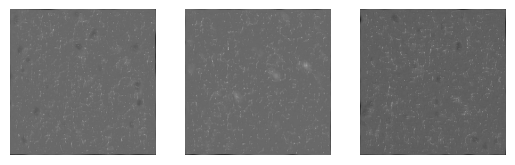

In [56]:
# Plot 3 examples from the synthetic data
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(syn_images[image_n, 0, :, :].cpu(), cmap="gray")
    ax[image_n].axis("off")

In [63]:
mmd_scores = []

mmd = MMDMetric()

for step, x in list(enumerate(val_loader)):
    image = x["image"].to(device)

    with torch.no_grad():
        image_recon = autoencoderkl.reconstruct(image)

    mmd_scores.append(mmd(image, image_recon))

mmd_scores = torch.stack(mmd_scores)
print(f"MMD score: {mmd_scores.mean().item():.8f} +- {mmd_scores.std().item():.8f}")

MMD score: 0.00011098 +- 0.00001062
